In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
np.set_printoptions(precision=5, suppress=True)
mpl.style.use('dark_background')

## Functions

In [3]:
def pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    shifted_A = A - np.mean(A, axis=0)
    shifted_B = B - np.mean(B, axis=0)
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(shifted_A * shifted_B, axis=0)) \
                / (np.sqrt(np.sum(shifted_A**2, axis=0) \
                            * np.sum(shifted_B**2, axis=0)) + eps)

In [4]:
def pixel_uncentered_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(A * B, axis=0)) \
                / (np.sqrt(np.sum(A**2, axis=0) \
                            * np.sum(B**2, axis=0)) + eps)

In [5]:
@tf.function
def batch_JJt_diag(x, model):
    # note that x should be a tf.Variable with N vectors
    # of length n
    #x = tf.Variable(x)
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return tf.reduce_sum(jacobians**2, axis=2)

In [6]:
def plot_images(left_images, right_images, main_title='TITLE',
               corr_scale=False):
    num_rows = len(left_images)
    fig, axs = plt.subplots(num_rows, 2,
                            figsize=(8, 4*num_rows),
                            constrained_layout=True)
    fig.suptitle(main_title, fontsize=20)
    
    # if the input images are correlations i.e. are bounded
    # to [-1,1], use Normalize class to apply transformation
    # on image that takes [-1,1], [0,1]
    corr_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
    for i in range(num_rows):
        # annotate with range of image as title
        left_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(left_images[i]),
            np.max(left_images[i]))
        axs[i,0].set_title(left_title)
        
        right_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(right_images[i]),
            np.max(right_images[i]))      
        axs[i,1].set_title(right_title)
        
        # either apply correlation normalization or default
        # normalization which maps min and max to 0 and 1 
        if corr_scale:
            axs[i,0].imshow(left_images[i], cmap='gray', norm=corr_norm)
            axs[i,1].imshow(right_images[i], cmap='gray', norm=corr_norm)
        else:
            axs[i,0].imshow(left_images[i], cmap='gray')
            axs[i,1].imshow(right_images[i], cmap='gray')
    plt.show()

In [42]:
def plot_loss_history(loss_history, step_history, min_step):
    # set axes limits to adapt to chosen minimum epoch
    xmin, xmax = min_step, step_history[-1]
    ymin = np.min(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*0.9
    ymax = np.max(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*1.1

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.plot(step_history, loss_history['loss'], label='loss')
    ax.plot(step_history, loss_history['val_loss'],
            label='validation loss')
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Mean Squared Error')
    ax.set_yscale('log')
    ax.legend()
    plt.show()

## Generate random "images"

In [8]:
# the original "images" size 10x10, flattened to 784
image_size = 10
y_train = np.random.rand(60000,image_size**2)
y_test = np.random.rand(10000,image_size**2)

# Have d = 28*28 = 784 as the dimensionality of the input vectors.
# Encode these vectors with dxn random matrix A, where n = 5 * d
A = np.random.randn(image_size,5*image_size**2)

# encode x_train and x_test by right-multiplying A
# x.shape = (N, d), A.shape = (d, n) -> output shape of (N, n)
if int(np.linalg.matrix_rank(A)) == image_size**2:
    x_train = y_train @ A
    x_test = y_test @ A
else:
    print('A not full rank')

In [9]:
# save encoded data to .npz archive
np.savez('normally-encoded-random-images-100.npz',
         x_train=x_train,
         x_test=x_test,
         y_train=y_train,
         y_test=y_test,
         A=A)

## Load data

In [1]:
# import encoded data from .npz archive
with np.load('normally-encoded-random-images-10.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']

NameError: name 'np' is not defined

## Load previous progress

In [41]:
# LOAD PREVIOUS PROGRESS
# load saved model
model = tf.keras.models.load_model('random-image-model-50K-5K')

In [25]:
# load correlation histories
with np.load('random-image-model-histories.npz') as data:
    image_corr_history = data['image_corr_history'].tolist()
    JJt_corr_history = data['JJt_corr_history'].tolist()
    JJt_uncent_corr_history = data['JJt_uncent_corr_history'].tolist()

# load loss history
loss_history = pd.read_csv('loss_history.csv').to_dict()

## Initialize model and histories

In [23]:
# INITIALIZE HISTORIES
image_size = 10
loss_history = {'loss':[], 'val_loss':[]}
image_corr_history = []
JJt_diags_history = []
JJt_uncent_corr_history = []
JJt_corr_history = []
step_history = []

In [24]:
# INITIALIZE MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50000, activation='relu', input_shape=(5*image_size**2,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(image_size**2)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
                   loss=loss_fn)

In [25]:
# history after zero training steps
step_history.append(0)

# evaluate loss
N = 1000
loss_history['loss'].append(model.evaluate(x_train[:N], y_train[:N]))
loss_history['val_loss'].append(model.evaluate(x_test[:N], y_test[:N]))

# find pixel correlations between original and output images
N = 100
original_images = np.reshape(y_test[:N], (N,image_size,image_size))
output_images = np.reshape(model(x_test[:N]), (N,image_size,image_size))
image_corr_history.append(pixel_corr(original_images, output_images))

# calculate correlation between the diagonal of J*Jt and the deviation
# squared of the noisy and noiseless reconstructed images
# get sample batches of noisy and noiseless input vectors
N = 50
x = x_test[:N]
# add WGN
sigma = np.std(x)/5 # choose sigma = 1/5 of original std
x_noisy = x + sigma*np.random.randn(N, 5*image_size**2)

# run both x and x_noisy through model, reshape to make "images"
noiseless_images = np.reshape(model(x), (N,image_size,image_size))
noisy_images = np.reshape(model(x_noisy), (N,image_size,image_size))
# get the deviation^2 pixel by pixel
dev_sq = (noiseless_images - noisy_images)**2
# get batch of JJt diagonals (each length 784) and reshape into 
# a batch of 28x28 "images"
JJt_diags = np.reshape(batch_JJt_diag(tf.Variable(x), model),
                       (N,image_size,image_size))

# append correlations and one element of JJt_diags to the histories
JJt_diags_history.append(JJt_diags[0,:,:])
JJt_corr_history.append(pixel_corr(dev_sq, JJt_diags))
JJt_uncent_corr_history.append(pixel_uncentered_corr(dev_sq, JJt_diags))

32/32 [==============================] - 5s 144ms/step - loss: 0.8984


## Train model

In [15]:
# recompile to change learning rate or momentum coefficient
model.compile(tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
                   loss=loss_fn)

In [49]:
# TRAINING LOOP
val_size = 1000
train_size = 500
batch_size = 25
train_start = 10000
for i in range(5):
    start_time = time.time()
    start_idx = train_start + i*train_size
    this_history = model.fit(x_train[start_idx:start_idx+train_size],
                                  y_train[start_idx:start_idx+train_size],
                                  validation_data=(x_test[:val_size],
                                                   y_test[:val_size]),
                                  epochs=1, verbose=1, batch_size=batch_size)
    train_time = time.time()
    print('Training time: {:.1f}'.format(train_time-start_time))

    # append to full loss history dict
    step_history.append(step_history[-1] + train_size/batch_size)
    loss_history['loss'] += this_history.history['loss']
    loss_history['val_loss'] += this_history.history['val_loss']

    # find pixel correlations between original and output images
    N = 100
    original_images = np.reshape(y_test[:N], (N,image_size,image_size))
    output_images = np.reshape(model(x_test[:N]), (N,image_size,image_size))
    image_corr_history.append(pixel_corr(original_images, output_images))

    # calculate correlation between the diagonal of J*Jt and the deviation
    # squared of the noisy and noiseless reconstructed images
    # get sample batches of noisy and noiseless input vectors
    N = 25
    x = x_test[:N]
    # add WGN
    sigma = np.std(x)/5 # choose sigma = 1/5 of original std
    x_noisy = x + sigma*np.random.randn(N, 5*image_size**2)

    # run both x and x_noisy through model, reshape to make "images"
    noiseless_images = np.reshape(model(x), (N,image_size,image_size))
    noisy_images = np.reshape(model(x_noisy), (N,image_size,image_size))
    # get the deviation^2 pixel by pixel
    dev_sq = (noiseless_images - noisy_images)**2
    # get batch of JJt diagonals (each length image_size^2) and reshape
    JJt_diags = np.reshape(batch_JJt_diag(tf.Variable(x), model),
                           (N,image_size,image_size))

    # append correlations and one element of JJt_diags to the histories
    JJt_diags_history.append(JJt_diags[0,:,:])
    JJt_corr_history.append(pixel_corr(dev_sq, JJt_diags))
    JJt_uncent_corr_history.append(pixel_uncentered_corr(dev_sq, JJt_diags))
    print('Correlations time: {:.1f}'.format(time.time()-train_time))
    print(' ')
    
    

20/20 [==============================] - 24s 1s/step - loss: 0.0072 - val_loss: 0.0072
Training time: 25.6
Correlations time: 9.3
 
20/20 [==============================] - 27s 1s/step - loss: 0.0068 - val_loss: 0.0065
Training time: 28.2
Correlations time: 9.7
 
20/20 [==============================] - 29s 1s/step - loss: 0.0065 - val_loss: 0.0065
Training time: 30.1
Correlations time: 11.0
 
20/20 [==============================] - 32s 2s/step - loss: 0.0064 - val_loss: 0.0063
Training time: 33.0
Correlations time: 12.0
 
20/20 [==============================] - 32s 2s/step - loss: 0.0060 - val_loss: 0.0061
Training time: 33.7
Correlations time: 12.0
 


In [ ]:
x = x_test[0]
# for
# add multiple different 500x1 random normal vectors
# run them all through the network
# calculate deviation^2 from model(x)
# calculating the jacobian at each of the noisy input vectors
# pixel correlations between JJt diags and dev^2

In [34]:
# SAVE PROGRESS
# save model weights as SavedModel instance
model.save('random-image-model-10')

# save correlation histories in .npz archive
# (i.e. as ndarrays)
np.savez('random-image-model-histories-10.npz',
         image_corr_history=np.array(image_corr_history),
         JJt_corr_history=np.array(JJt_corr_history),
         JJt_uncent_corr_history=np.array(JJt_uncent_corr_history))
 
# save loss histories as .CSV through pd.DataFrame
pd.DataFrame(loss_history).to_csv('loss_history-10.csv', index=False)
print('Saving time: {:.1f}'.format(time.time()-start_time))

INFO:tensorflow:Assets written to: random-image-model-10\assets
Saving time: 342.5


## Loss History

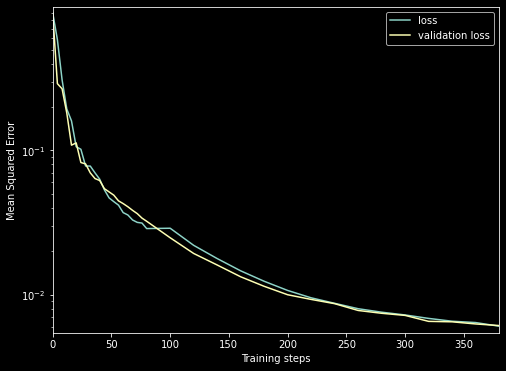

In [50]:
plot_loss_history(loss_history, step_history, min_step=0)

## Original vs. output images

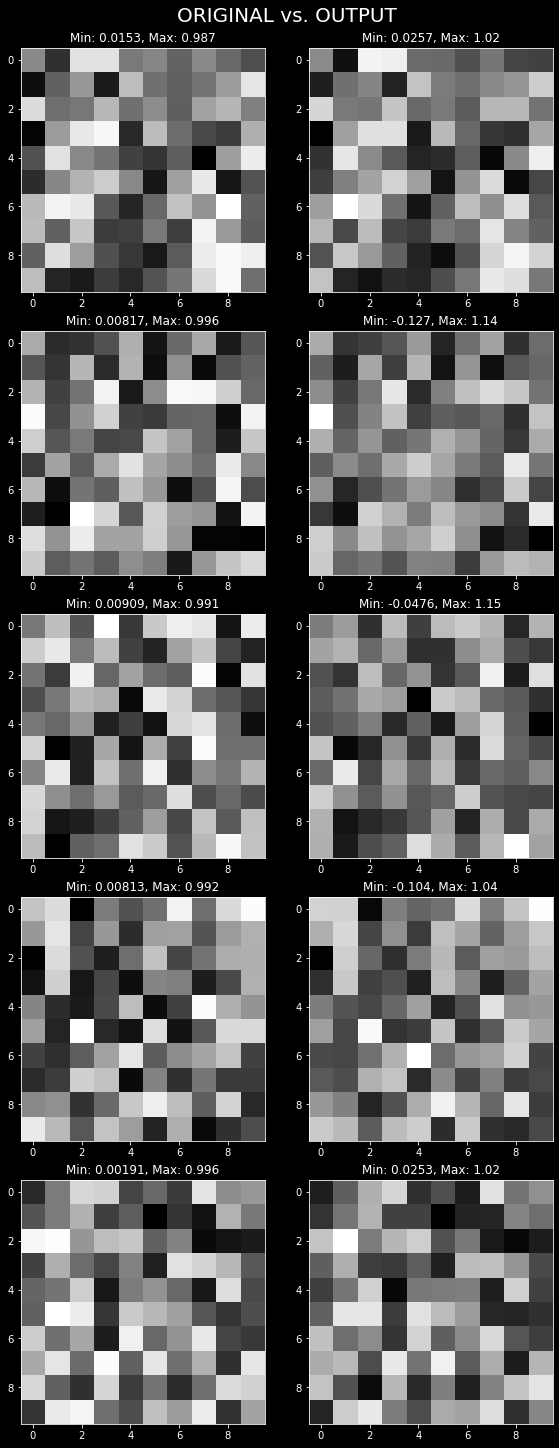

In [51]:
plot_images(np.reshape(y_test[:5], (5,image_size,image_size)),
           np.reshape(model(x_test[:5]), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

## Random model on Fashion MNIST dataset

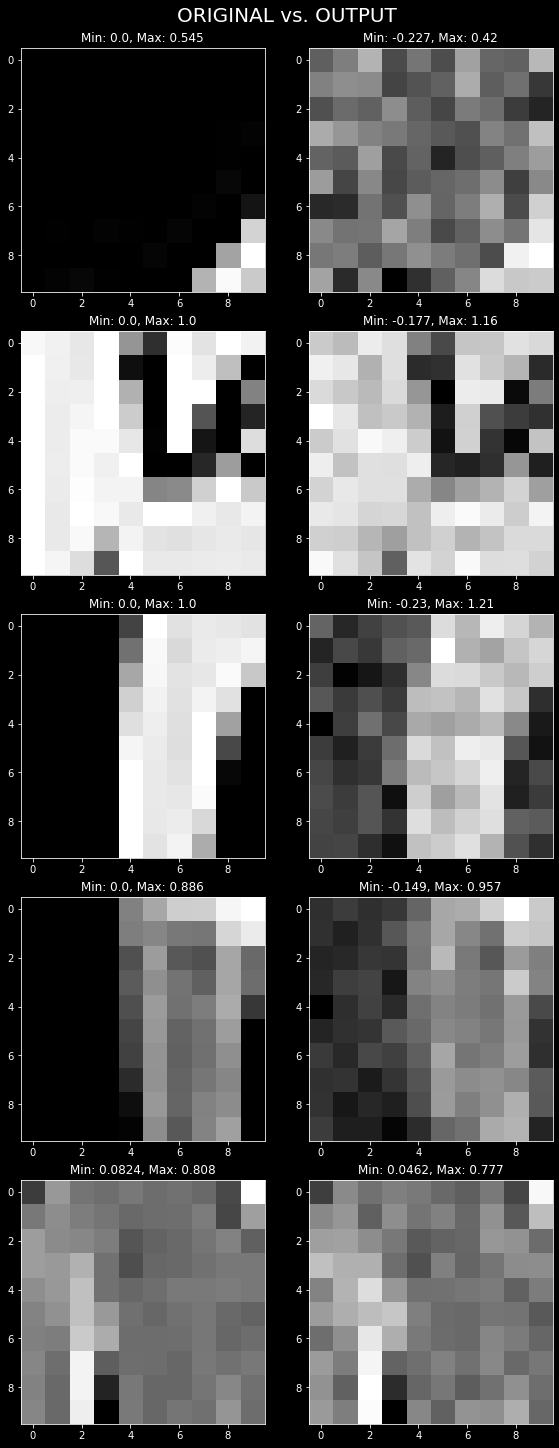

In [72]:
# crop 10x10 bits of the images
y_cropped = np.reshape(np.reshape(y_fash[:5],(5,28,28))[:,5:15,5:15],
                       (5,100))
x_cropped = y_cropped @ A

plot_images(np.reshape(y_cropped, (5,image_size,image_size)),
           np.reshape(model(x_cropped), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

## Noise propagation through pseudo-inverse

In [52]:
# load Fashion MNIST data
# import encoded data from .npz archive
with np.load('normally-encoded-fashion-mnist.npz') as data:
    x_fash = data['x_test']
    y_fash = data['y_test']
    A_fash = data['A']

In [53]:
A_fash_sharp = np.linalg.pinv(A_fash)

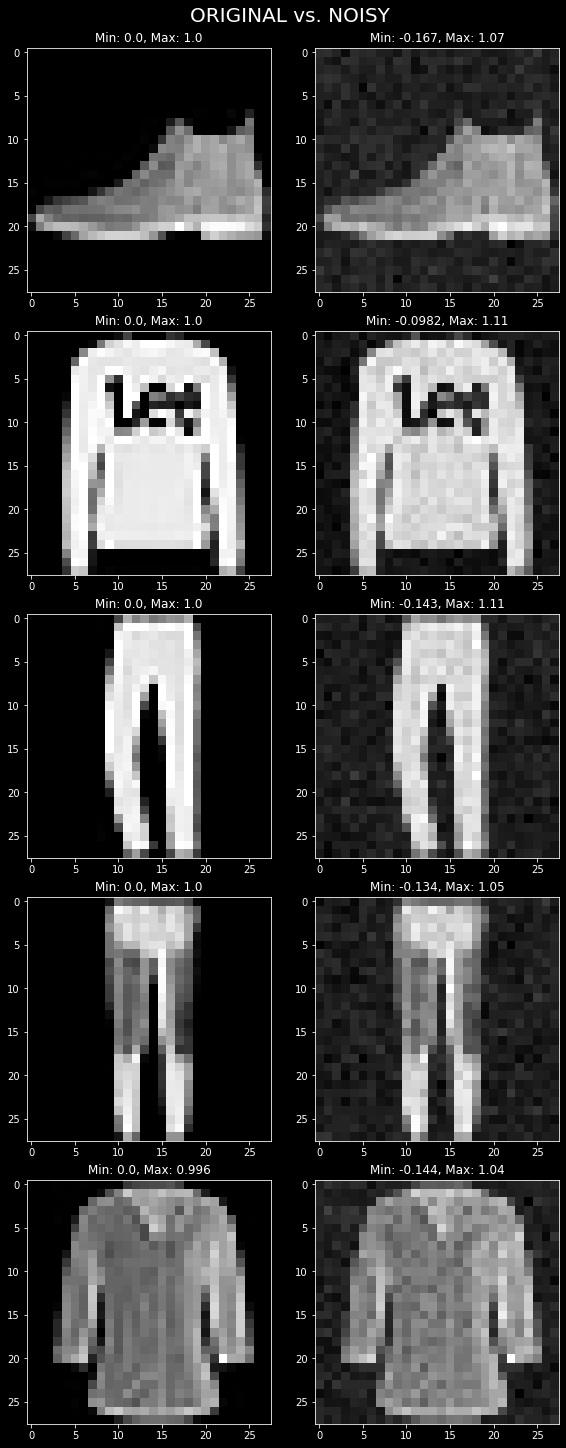

In [56]:
N = 5
# add noise to input vectors x_test
sigma = np.std(x_fash[:N])/5 # choose sigma = 1/5 of original std
x_fash_noisy = x_fash[:N] + sigma*np.random.randn(N, 5*28**2)
y_fash_noisy = x_fash_noisy @ A_fash_sharp

plot_images(np.reshape(y_fash[:N], (N,28,28)),
            np.reshape(y_fash_noisy, (N,28,28)),
            main_title='ORIGINAL vs. NOISY')

## Correlations

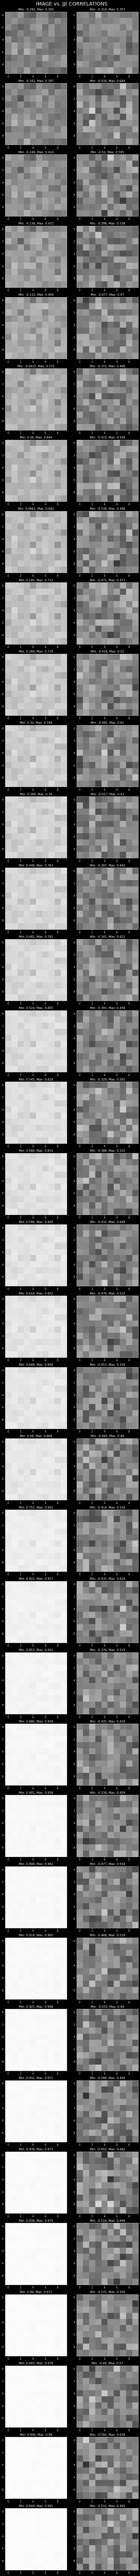

In [76]:
plot_images(image_corr_history, JJt_corr_history,
            main_title='IMAGE vs. JJt CORRELATIONS',
           corr_scale=True)

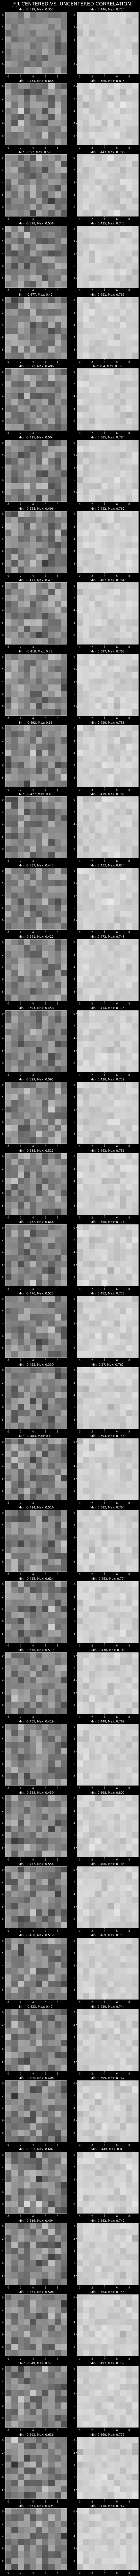

In [77]:
plot_images(JJt_corr_history, JJt_uncent_corr_history,
           main_title='J*Jt CENTERED VS. UNCENTERED CORRELATION',
           corr_scale=True)

In [ ]:
N = 25
x = x_test[:N]
# add WGN
sigma = np.std(x)/5 # choose sigma = 1/5 of original std
x_noisy = x + sigma*np.random.randn(N, 5*image_size**2)

# run both x and x_noisy through model, reshape to make "images"
noiseless_images = np.reshape(model(x), (N,image_size,image_size))
noisy_images = np.reshape(model(x_noisy), (N,image_size,image_size))
# get the deviation^2 pixel by pixel
dev_sq = (noiseless_images - noisy_images)**2
# get batch of JJt diagonals (each length image_size^2) and reshape
JJt_diags = np.reshape(batch_JJt_diag(tf.Variable(x), model),
                       (N,image_size,image_size))

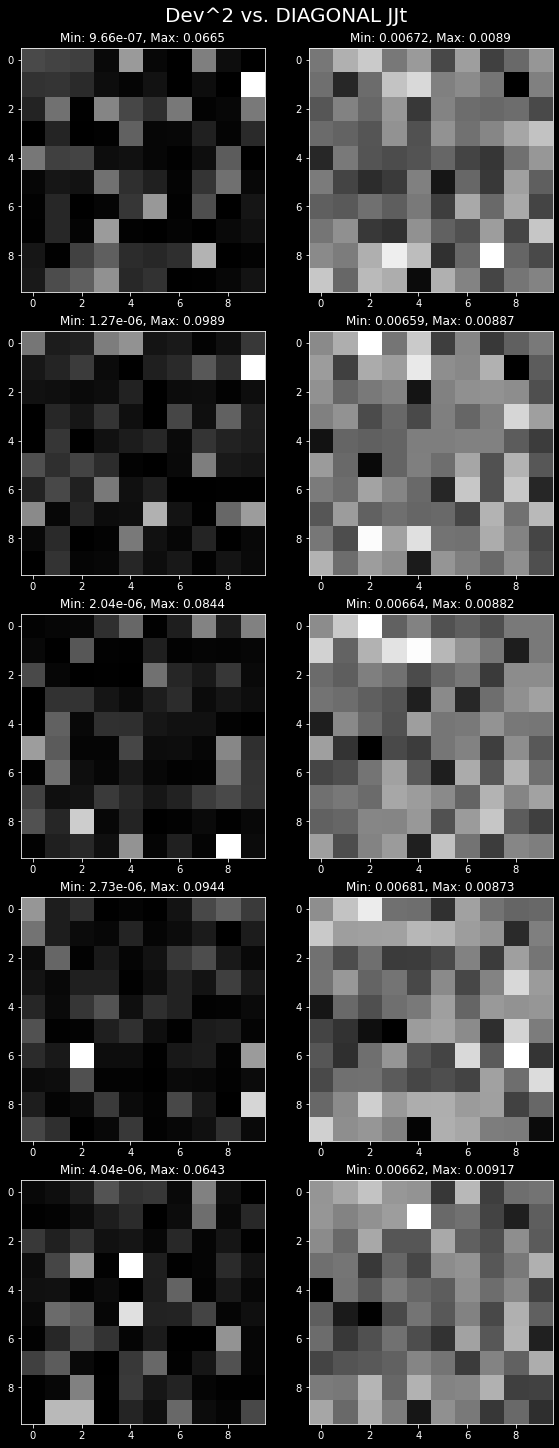

In [76]:
N = 5
# add noise to input vectors x_test
sigma = np.std(x_test[:N])/5 # choose sigma = 1/5 of original std
x_noisy = x_test[:N] + sigma*np.random.randn(N, 5*image_size**2)

original_images = np.reshape(y_test[:N], (N,image_size,image_size))
output_images = np.reshape(model(x_noisy), (N,image_size,image_size))
# get the deviation^2 pixel by pixel
dev_sq = (output_images - original_images)**2
JJt_diags = np.reshape(batch_JJt_diag(tf.Variable(x_noisy), model),
                       (N,image_size,image_size))
plot_images(dev_sq, JJt_diags, main_title='Dev^2 vs. DIAGONAL JJt')

## Correlation evolution

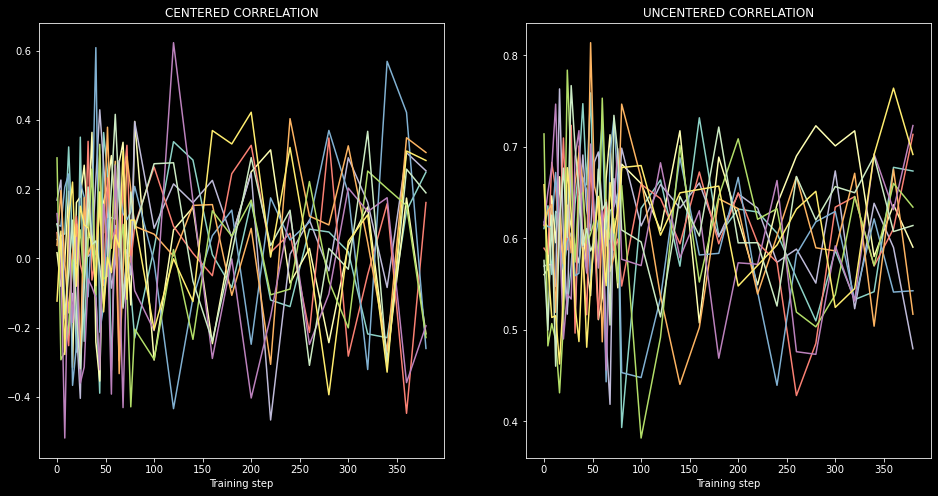

In [79]:
fig, axs = plt.subplots(1,2,figsize=(16,8))

uncentered = np.array(JJt_uncent_corr_history)
centered = np.array(JJt_corr_history)

axs[0].set_title('CENTERED CORRELATION')
axs[1].set_title('UNCENTERED CORRELATION')

axs[0].set_xlabel('Training step')
axs[1].set_xlabel('Training step')
for i in range(10):
    axs[0].plot(step_history, centered[:,i,i])
    axs[1].plot(step_history, uncentered[:,i,i])


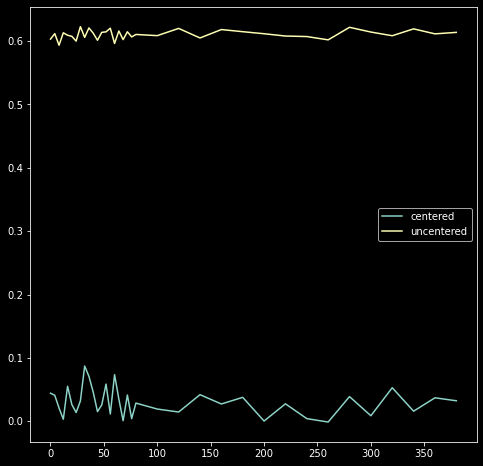

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

uncentered = np.array(JJt_uncent_corr_history)
centered = np.array(JJt_corr_history)

ax.plot(step_history, np.mean(centered, (1,2)), label='centered')
ax.plot(step_history, np.mean(uncentered, (1,2)), label='uncentered')
ax.legend()
plt.show()

## New graphs

### 1. Correlation vs. $\sigma$
#### For many different levels of sigma, add multiple different realizations of Gaussian noise to a *single* clean image, calculate dev^2 of each noisy network output to the clean network output, correlate to Jacobian evaluated at each noisy input
#### If trends aren't obvious from that plot, repeat the above for *multiple* clean images and average over each pixel (?)


### 2. MSE vs. $\sigma$
#### For many different levels of sigma, add multiple different realizations of Gaussian noise to a *single* clean image, calculate dev^2 of each noisy network output, but now average over pixel series and plot vs. sigma. Should be somewhat linear until higher-order terms kick in. That initial slope could possibly be close to what's predicted by the pseudo-inverse (?? not sure how we get a single number for each pixel from the pseudo-inverse)

Have some linear model $\vec{y} = B \vec{x}$, so for perturbed input $\vec{x}' = \vec{x} + \sigma \vec{w}$, where each element of $\vec{w}$ is a sample from i.i.d. $N(0,1)$, have
$$\vec{y}' - \vec{y} = \sigma B \vec{w}$$
Look at the expectation of one entry of the elementwise square:
$$E[(y_i' - y_i)^2] = \sigma^2 E[(\Sigma_j B_{ij}w_j)^2]= \sigma^2 E[\Sigma_j(B_{ij}^2w_j^2) + \Sigma_j \Sigma_{k\neq j}(B_{ij}B_{ik}w_jw_k)] = \sigma^2 \Sigma_j B_{ij}^2$$
The last step using $E[w_j^2] = 1$ and $E[w_j w_k] = E[w_j] E[w_k] = 0$ for $j \neq k$